In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.integrate import odeint
from glob import glob
import pickle
from sklearn.linear_model import LinearRegression
from pathlib import Path
#from nufeb_tools import utils,plot
import seaborn as sns

In [8]:
BASE_DIR = Path(f'D:/runs/axenic-cyanobacteria/')
Run_folders = glob('D:/runs/axenic-cyanobacteria/Sucrose_*/')
ExportRatio = np.linspace(0,1,len(Run_folders))

In [13]:
types = ['D:/runs/axenic-cyanobacteria/Sucrose_%.1f/Results/ntypes.csv'%i for i in ExportRatio]
biomass = ['D:/runs/axenic-cyanobacteria/Sucrose_%.1f/Results/biomass.csv'%i for i in ExportRatio]
Cons = ['D:/runs/axenic-cyanobacteria/Sucrose_%.1f/Results/avg_concentration.csv'%i for i in ExportRatio]
ExpPath = 'C:/Users/Jonathan/OneDrive - Michigan State University/Analysis/Biomass CscB-SPS-EmR.xlsx'
Experimental = pd.read_excel(ExpPath,sheet_name='Compiled')
Experimental.Time = Experimental.Time/24
#IPTG = pd.read_excel(ExpPath,sheet_name='+IPTG')
#IPTG.Time = IPTG.Time/24
SucroseMW = 342.3
O2MW = 32
CO2MW = 44.01
dens = 1e9
Volume = 1e-4*1e-4*1e-5 #m^3
CellNum2OD = Volume*1e6/0.3e-8
Biomass2OD = 1e12
tStep2Days = 10/3600/24
sucs = np.linspace(0,1,6)
pctC = 0.5
light = 1.00e-01 #kg/m^3
co2 = 4e-1
mu_max = 0.047*24 #2.25e-05# 1/d
K_m_light = 3.5e-04
K_m_co2 = 5e-2
# y= mu_max
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

dfs = []
for ntype,con,bio,i,sucR in zip(types,Cons,biomass,range(1,len(Run_folders)+1),ExportRatio):
    #n_types
    df1 = pd.read_csv(ntype,usecols=[0,1],names=['Time','OD600'],skiprows=1,delimiter='	')

    df1.iloc[:,1] = df1.iloc[:,1]/CellNum2OD
    
    #avg_con
    df2 = pd.read_csv(con,usecols=[0,2,3,4],names=['Time','O2','Sucrose','CO2'],skiprows=1,delimiter='	')
    #df2.index = df2.index*tStep2Days
    #df2.index.name='Days'
    df2.O2 = df2.O2/O2MW*1e3
    df2.Sucrose = df2.Sucrose/SucroseMW*1e3
    df2['CO2'] = df2['CO2']/CO2MW*1e3
    
    # biomass
    df3 = pd.read_csv(bio,usecols=[0,1],names=['Time','Biomass'],skiprows=1,delimiter='	')
    #df3.index = df3.Time*tStep2Days*24
    df3.Biomass = df3.Biomass*Biomass2OD
    df2['SucroseVol'] = df2.Sucrose*Volume*1e18/df1.OD600
      
    reg = LinearRegression()
    reg.fit(df2[:10].index.values.reshape(-1, 1),df2[:10].SucroseVol)
    df2['Productivity'] = reg.coef_[0]/1e2
    CellMass = df3[df3.index <= 24].Biomass.iloc[-1]/Biomass2OD/Volume# - df.Biomass.iloc[0]

    SucMass = df2[df2.index <= 24].iloc[-1].Sucrose# - df2.Sucrose.iloc[0]
    TotalMass = CellMass + SucMass
    
    df = pd.concat([df1.iloc[:,1],df2,df3.iloc[:,1]],axis=1)
    df.Time = df.Time/60/60/24*10 #convert timesteps (10s) to days
    #df.index.name='Days'
    df['SucroseExport'] = sucR
    df['CellMass']= CellMass
    df['SucMass'] = SucMass
    df['TotalMass'] = TotalMass
    df['RelCell'] = CellMass/TotalMass
    df['RelSuc'] = SucMass/TotalMass
    df['Ratio'] = TotalMass/CellMass
    dfs.append(df)
df = pd.concat(dfs)

    #ax.plot(df.iloc[:,1],label=f'Sucrose Export {ExportRatio[i-1] :.2f}')


In [10]:
df.CellMass.unique()

array([0.439674 , 0.4274656, 0.4155923, 0.4040451, 0.3928151, 0.3818937,
       0.3712725, 0.3609434, 0.3508983, 0.3411297, 0.33163  ])

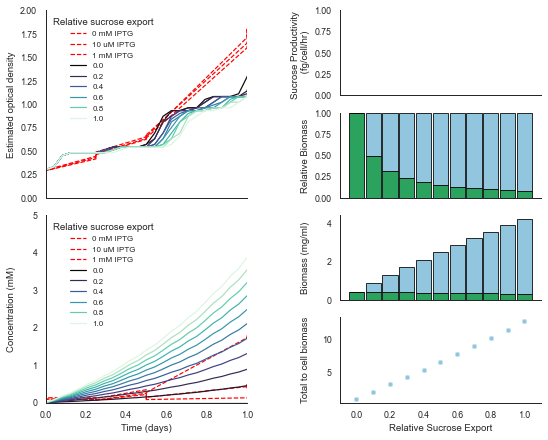

In [20]:
#f,axes = plt.subplots(nrows=4,ncols=2,figsize=(12,15))
fig = plt.figure(constrained_layout=True, figsize=(7.5,6))
gs0 = gridspec.GridSpec(4, 2, figure=fig)
sns.set_context('paper')
sns.set_style('white')

ax2 = fig.add_subplot(gs0[2:, 0])
ax1 = fig.add_subplot(gs0[:2, 0],sharex=ax2)

ax6 = fig.add_subplot(gs0[3,1])
ax3 = fig.add_subplot(gs0[0,1],sharex=ax6)
ax4 = fig.add_subplot(gs0[1,1],sharex=ax6)
ax5 = fig.add_subplot(gs0[2,1],sharex=ax6)

iptg = [0,1e-5,1e-3]
labels = ['0 mM IPTG','10 uM IPTG','1 mM IPTG']
for induction,label in zip(iptg,labels):
    temp = Experimental[Experimental.IPTG==induction]
    ax1.plot(temp.Time,temp.OD750,label=label,c='red',ls='--')
#ax1.plot(IPTG.Time,IPTG.OD,label='+IPTG',c='grey',ls='--')
sns.lineplot(x='Time',y='OD600',hue='SucroseExport',data=df,ax=ax1,palette='mako')

for induction,label in zip(iptg,labels):
    temp = Experimental[Experimental.IPTG==induction]
    ax2.plot(temp.Time,temp.Sucrose/SucroseMW*1e3,label=label,c='red',ls='--')
#ax2.plot(Experimental.Time,Experimental.Sucrose,label='Control',c='red',ls='--')
#ax2.plot(IPTG.Time,IPTG.Sucrose,label='+IPTG',c='grey',ls='--')
sns.lineplot(x='Time',y='Sucrose',hue='SucroseExport',data=df,ax=ax2,palette='mako')
sns.despine()
ax2.set_xlabel('Time (days)')
ax1.set_ylabel(r'Estimated optical density')
ax2.set_ylabel('Concentration (mM)')
#ax1.set_xlim([0,2])
ax2.set_xlim([0,1])
ax1.set_ylim([0,2])
ax2.set_ylim([0,5])
ax1.legend(frameon=False,title='Relative sucrose export',fontsize='small')
ax2.legend(frameon=False,loc='upper left',title='Relative sucrose export',fontsize='small')

#sns.scatterplot(x='SucroseExport',y='Productivity',data=df,ax=ax3,color='#92c5de')
#sns.barplot(x='SucroseExport',y='CellMass',data=df,ax=axes[1,1])
width = 1/len(Run_folders)
ax4.bar(ExportRatio,df.RelCell.unique(),width,label='Cell Biomass',edgecolor='k',color='#2ca25f')
ax4.bar(ExportRatio,df.RelSuc.unique(),width,bottom=df.RelCell.unique(),label='Sucrose Biomass',edgecolor='k',color='#92c5de')

ax5.bar(ExportRatio,df.CellMass.unique(),width,label='Cell Biomass',edgecolor='k',color='#2ca25f')
ax5.bar(ExportRatio,df.SucMass.unique(),width,bottom=df.CellMass.unique(),label='Sucrose Biomass',edgecolor='k',color='#92c5de')
sns.scatterplot(x='SucroseExport',y='Ratio',data=df,ax=ax6,color='#92c5de')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax5.get_xticklabels(), visible=False)
ax1.set_xlabel('')
ax3.set_xlabel('')
ax3.set_ylabel('Sucrose Productivity \n (fg/cell/hr)')
ax4.set_ylabel('Relative Biomass')
ax5.set_ylabel('Biomass (mg/ml)')
ax6.set_xlabel('Relative Sucrose Export')
ax6.set_ylabel('Total to cell biomass')
fig.align_ylabels()
#fig.savefig('validationSE.png',dpi=600)
#f.tight_layout()



In [12]:
df

,OD600,Time,O2,Sucrose,CO2,SucroseVol,Productivity,Biomass,SucroseExport,CellMass,SucMass,TotalMass,RelCell,RelSuc,Ratio
0,0.30,0.000000,0.281250,2.921414e-20,999.772779,9.738047e-15,-4.052741e-18,0.010634,0.0,0.439674,2.921414e-20,0.439674,1.000000,6.644500e-20,1.000000
1,0.33,0.041667,0.498305,2.921414e-20,999.553511,8.852770e-15,-4.052741e-18,0.011174,0.0,0.439674,2.921414e-20,0.439674,1.000000,6.644500e-20,1.000000
2,0.45,0.083333,0.804955,2.921414e-20,999.244035,6.492031e-15,-4.052741e-18,0.011936,0.0,0.439674,2.921414e-20,0.439674,1.000000,6.644500e-20,1.000000
3,0.48,0.125000,1.048607,2.921414e-20,998.998409,6.086279e-15,-4.052741e-18,0.012542,0.0,0.439674,2.921414e-20,0.439674,1.000000,6.644500e-20,1.000000
4,0.48,0.166667,1.392834,2.921414e-20,998.651216,6.086279e-15,-4.052741e-18,0.013398,0.0,0.439674,2.921414e-20,0.439674,1.000000,6.644500e-20,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,9.93,3.000000,795.203437,5.426264e+01,200.935310,5.464515e+05,2.127591e+02,0.326831,1.0,0.331630,3.866935e+00,4.198565,0.078987,9.210135e-01,12.660391
73,10.44,3.041667,828.459687,5.653266e+01,167.526926,5.415006e+05,2.127591e+02,0.340059,1.0,0.331630,3.866935e+00,4.198565,0.078987,9.210135e-01,12.660391
74,11.22,3.083333,874.904063,5.970292e+01,120.871143,5.321116e+05,2.127591e+02,0.358533,1.0,0.331630,3.866935e+00,4.198565,0.078987,9.210135e-01,12.660391
75,11.94,3.125000,923.870938,6.304537e+01,71.682958,5.280182e+05,2.127591e+02,0.378010,1.0,0.331630,3.866935e+00,4.198565,0.078987,9.210135e-01,12.660391
